In [40]:
import os
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from analysis._utils import *
import yaml

In [41]:
config = OmegaConf.load("../conf/analysis.yaml")
configs = {}
for file_path in find_config_files("../logs/hydra"):
    with open(file_path, 'r') as f:
        data = yaml.safe_load(f)
        parent_dir = os.path.dirname(file_path)
        if os.path.exists(os.path.join(parent_dir, "loss_curves.csv")):
            loss_df = pd.read_csv(os.path.join(parent_dir, "loss_curves.csv"), index_col=0)
            loss = loss_df["centered_test_losses"][loss_df["centered_test_losses"].idxmin()]
            configs[os.path.dirname(file_path)] = (loss, OmegaConf.create(data))
configs["../logs/hydra/2023_04_13_10_47_07/0"]

(0.19396606,
 {'preprocess': {'url': 'https://www.dropbox.com/s/lw9cblxawqsbr2w/opensource_data.zip?dl=1', 'zipfile': 'opensource_data.zip', 'dataset': 'all', 'raw_dir': 'data/raw', 'smooth': 'fft'}, 'dataset': {'name': 'Uzel2022'}, 'model': {'type': 'NetworkLSTM', 'input_size': 302, 'hidden_size': 128, 'num_layers': 1, 'loss': 'l1'}, 'visualize': {'log_dir': 'logs/hydra/2023_04_13_10_47_07/0', 'worm': 'worm1', 'neuron': 'AVAL'}, 'train': {'learn_rate': 0.01, 'seq_len': 99, 'k_splits': 2, 'epochs': 200, 'save_freq': 100, 'smooth_data': True, 'reverse': False, 'num_batches': 1, 'train_size': 6, 'test_size': 498, 'shuffle': True, 'tau_in': 1, 'tau_out': 1, 'optimizer': 'SGD'}, 'globals': {'use_residual': False, 'shuffle': False}, 'timestamp': '2023_04_13_10_47_28', 'num_unique_worms': 6, 'worm_timesteps': 594})

In [42]:
trailing_dict = {}
for key, value in configs.items():
    dataset_name = value[1]["dataset"]["name"]
    train_size = value[1]["train"]["train_size"]
    loss = value[0]
    print(f"{dataset_name} {train_size} {loss}")
    if dataset_name in trailing_dict.keys():
        trailing_dict[dataset_name].update({train_size: loss})
    else:
        trailing_dict[dataset_name] = {train_size: loss}

Kato2015 12 0.10379674
Kato2015 15160 0.07705193
Kato2015 9996 0.07017329
Kato2015 48 0.08444889
Kato2015 996 0.07005784
Kato2015 492 0.07782983
Kato2015 96 0.079199284
Kato2015 4992 0.073489524
Flavell2023 1000 0.112599604
Skora2018 12 0.1328415
Flavell2023 5000 0.11112149
Flavell2023 500 0.11691156
Skora2018 492 0.09302719
Flavell2023 10 0.16192414
Skora2018 4992 0.09325207
Skora2018 996 0.09017254
Skora2018 96 0.095376104
Flavell2023 8000 0.11235961
Flavell2023 50 0.12579742
Skora2018 48 0.09631737
Flavell2023 8000 0.1182387
Flavell2023 100 0.1216736
Uzel2022 6 0.19396606
Uzel2022 11629 0.10282726
Uzel2022 9965 0.107525885
Uzel2022 48 0.120046854
Uzel2022 996 0.102341406
Uzel2022 498 0.10342814
Uzel2022 96 0.11637804
Uzel2022 4998 0.10192169


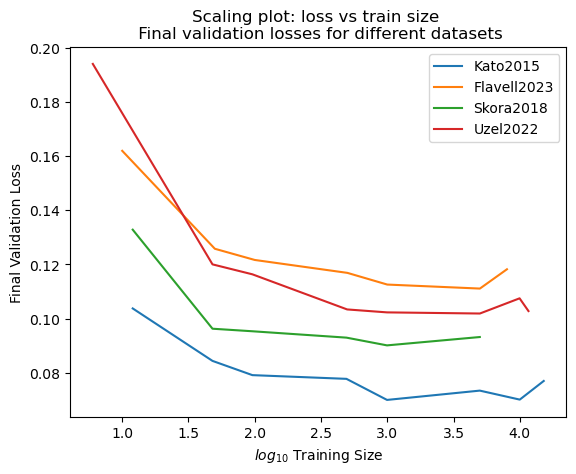

In [43]:
x = []
for dataset_name, dataset_dict in trailing_dict.items():
    # if dataset_name == "Flavell2023":
    #     continue
    sorted_x, sorted_y = zip(*sorted(zip(list(dataset_dict.keys()), list(dataset_dict.values()))))
    x = sorted_x
    plt.plot(np.log10(sorted_x), sorted_y, label=dataset_name)
plt.legend()
plt.xlabel("$log_{10}$ Training Size")
plt.ylabel("Final Validation Loss")
plt.title("Scaling plot: loss vs train size \n Final validation losses for different datasets")
plt.savefig("figures/trailing_loss.png")

In [44]:
def plot_trailing_loss_vs_parameter_legend(config_pardir, parameter, legend):
    configs = {}
    # go through all the config files and get the parameters and the loss
    for file_path in find_config_files(config_pardir):
        with open(file_path, 'r') as f:
            data = yaml.safe_load(f)
            parent_dir = os.path.dirname(file_path)
            if os.path.exists(os.path.join(parent_dir, "loss_curves.csv")):
                loss_df = pd.read_csv(os.path.join(parent_dir, "loss_curves.csv"), index_col=0)
                loss = loss_df["centered_test_losses"][loss_df["centered_test_losses"].idxmin()]
                configs[os.path.dirname(file_path)] = (loss, OmegaConf.create(data))

    parameters = parameter.split(".")
    param_name = parameters[1]
    legends = legend.split(".")

    # get the trailing loss for each parameter value
    trailing_dict = {}
    for key, value in configs.items():
        legend_name = value[1][legends[0]][legends[1]]
        param_value = value[1][parameters[0]][parameters[1]]
        loss = value[0]
        print(f"{legend_name} {param_value} {loss}")
        if legend_name in trailing_dict.keys():
            trailing_dict[legend_name].update({param_value: loss})
        else:
            trailing_dict[legend_name] = {param_value: loss}

    # plot the trailing loss for each parameter value
    x = []
    for para_n, val_dict in trailing_dict.items():
        sorted_x, sorted_y = zip(*sorted(zip(list(val_dict.keys()), list(val_dict.values()))))
        x = sorted_x
        plt.plot(np.log10(sorted_x), sorted_y, label=para_n)

    plt.legend()
    plt.xlabel("$log_{10}$ Training Size")
    plt.ylabel("Final Validation Loss")
    plt.title("Scaling plot: loss vs train size \n Final validation losses for different datasets")
    plt.savefig("figures/trailing_loss.png")

Kato2015 12 0.10379674
Kato2015 15160 0.07705193
Kato2015 9996 0.07017329
Kato2015 48 0.08444889
Kato2015 996 0.07005784
Kato2015 492 0.07782983
Kato2015 96 0.079199284
Kato2015 4992 0.073489524
Flavell2023 1000 0.112599604
Skora2018 12 0.1328415
Flavell2023 5000 0.11112149
Flavell2023 500 0.11691156
Skora2018 492 0.09302719
Flavell2023 10 0.16192414
Skora2018 4992 0.09325207
Skora2018 996 0.09017254
Skora2018 96 0.095376104
Flavell2023 8000 0.11235961
Flavell2023 50 0.12579742
Skora2018 48 0.09631737
Flavell2023 8000 0.1182387
Flavell2023 100 0.1216736
Uzel2022 6 0.19396606
Uzel2022 11629 0.10282726
Uzel2022 9965 0.107525885
Uzel2022 48 0.120046854
Uzel2022 996 0.102341406
Uzel2022 498 0.10342814
Uzel2022 96 0.11637804
Uzel2022 4998 0.10192169


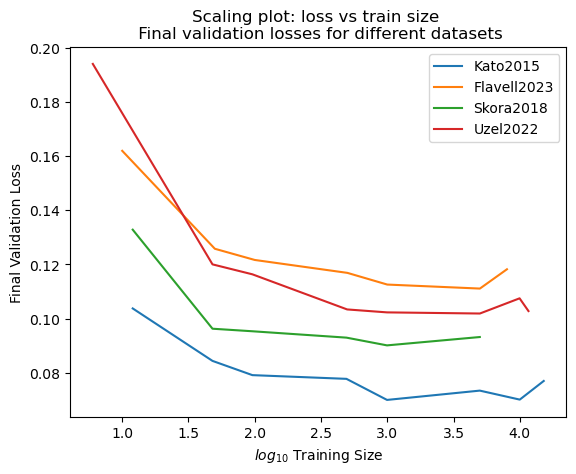

In [45]:
plot_trailing_loss_vs_parameter_legend("../logs/hydra", "train.train_size", "dataset.name")